# Preprocessing Raw EEGNet Data

In [1]:
import numpy as np
import pandas as pd
import glob
import time
from scipy import signal
from tqdm.notebook import tqdm
import copy

In [2]:
train_files = glob.glob('data/Train/Data*.csv')
test_files = glob.glob('data/Test/Data*.csv')
print(train_files[:5])

['data/Train\\Data_S02_Sess01.csv', 'data/Train\\Data_S02_Sess02.csv', 'data/Train\\Data_S02_Sess03.csv', 'data/Train\\Data_S02_Sess04.csv', 'data/Train\\Data_S02_Sess05.csv']


In [3]:
# CONSTANTS
training_subjects = 16 #num of training subjects
num_of_fb = 340 #num of feedbacks / subject
freq = 200 #sampling rate
epoch_time = 0.5 #proposed epoching time in seconds
epoch = int(freq * epoch_time) #epoch in indices
pre_fb_time = 0.1
pre_fb = int(freq * pre_fb_time) #sampling time before the feedback
num_of_cols = 59
eeg_cols = 6
b_s = int(-0.4*freq) #index where baseline starts relative to feedback (-400ms)
b_e = int(-0.3*freq) #index where baseline ends relative to feedback (-300ms)
order = 2 #butterworth order
low_pass = 0.1 #low frequency pass for butterworth filter
high_pass = 20. #high frequency pass for butterworth filter

all_channels = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1',
               'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
               'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2',
               'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4',
               'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
               'PO7', 'POz', 'P08', 'O1', 'O2']
channels = ['Fz', 'FCz', 'Cz', 'CPz', 'Pz', 'POz']
# [10, 19, 28, 37, 46, 52]
channels_indices = []
for channel in channels:
    channels_indices.append(all_channels.index(channel))
    

In [4]:
def butter_filter(order, low_pass, high_pass, fs,sig):
    nyq = 0.5 * fs
#     lp = low_pass / nyq
#     hp = high_pass / nyq
    lp = low_pass
    hp = high_pass
    coeffs = [lp, hp]
    btype = 'bandpass'
#     sos = signal.butter(order, [lp, hp], btype=btype, output = 'sos', fs = 200)
#     return signal.sosfiltfilt(sos, sig, axis=0)
    b = signal.firwin(numtaps=151, cutoff=coeffs, pass_zero=btype, fs=200) # order = odd number (31 - 201)
    a = 1
    filt = signal.filtfilt(b, a, sig, axis=0)
    return filt



def extract_data(files, e_s = None, baseline = True, bandpass = True):
    start = time.time()
    
    temp = np.empty((1,epoch+pre_fb, len(channels)), float)
    enum_files = list(enumerate(files))
    for i, f in tqdm(enum_files):
        df = pd.read_csv(f) #read each file
        index_fb = df[df['FeedBackEvent'] == 1].index.values
        df_array = np.array(df) 
        
        #uncomment below for butterworth filter or firwin filter
        if bandpass == True:
            eeg = df_array[:, channels_indices] #only eeg values to apply butterworth filter
            for i, channel in enumerate(channels):
                raw_eeg = df[channel].values
                eeg_filtered = butter_filter(order, low_pass, high_pass, freq, raw_eeg) #butterworth filter applied
                eeg[:,i] = eeg_filtered
            df = np.array(df)
            df[:, channels_indices] = eeg #replacing old eeg values with new ones
        else:
            df = np.array(df)
        
        for j, indx in enumerate(index_fb): #epoching 100 indexes (0.5 seconds) after each stimulus
            epoch_array = df[indx-pre_fb:indx+epoch, channels_indices]
            epoch_array = epoch_array.reshape((1, epoch_array.shape[0], epoch_array.shape[1]))

            #uncomment below for baseline correction
            if baseline == True:
                #baseline correction of 100ms (20 indexes), 400ms to 300ms before fb
                baseline_array = df[indx+b_s:indx+b_e, channels_indices] 
                baseline_array = baseline_array.reshape((1,20,int(baseline_array.shape[1])))
                baseline_mean = np.mean(baseline_array, axis = 1)
                #noise subtracted from epoched data
                epoch_array[:,:,:] = epoch_array[:,:,:] - baseline_mean
                
            temp = np.vstack((temp,epoch_array))
                
    now = time.time()
    print('Elapsed Time: ' + str(int(now-start)) + ' seconds')
    return temp

In [5]:
train = extract_data(train_files) # 80 iterations
print(train.shape)
test = extract_data(test_files) # 50 iterations
print(test.shape)
np.save('tr1.npy',train[1:,:,:])
np.save('te1.npy',test[1:,:,:])

train = np.load('tr1.npy')
test = np.load('te1.npy')

  0%|          | 0/80 [00:00<?, ?it/s]

Elapsed Time: 149 seconds
(5441, 120, 6)


  0%|          | 0/50 [00:00<?, ?it/s]

Elapsed Time: 83 seconds
(3401, 120, 6)


In [6]:
train_shape = train.shape[0]
test_shape = test.shape[0]

train = np.reshape(train, (train_shape, eeg_cols, epoch + pre_fb))
test = np.reshape(test, (test_shape, eeg_cols, epoch + pre_fb))

EEG_train = train[:,:,:].reshape(5440*(epoch + pre_fb), eeg_cols)
EEG_test = test[:,:,:].reshape(3400*(epoch + pre_fb), eeg_cols)

train_filtered = EEG_train.reshape(5440, int(eeg_cols), epoch + pre_fb)
test_filtered = EEG_test.reshape(3400, int(eeg_cols), epoch + pre_fb)

print(train_filtered.shape)
print(test_filtered.shape)


(5440, 6, 120)
(3400, 6, 120)


In [7]:
train_filtered[0].shape

(6, 120)

In [8]:
np.save('data/X_train_bwbs.npy',train_filtered)
np.save('data/X_test_bwbs.npy',test_filtered)

# Generate Graphs

In [9]:
import matplotlib.pyplot as plt

In [10]:
train_files = glob.glob('data/train/Data*.csv')
test_files = glob.glob('data/test/Data*.csv')
print(train_files[:5])

['data/train\\Data_S02_Sess01.csv', 'data/train\\Data_S02_Sess02.csv', 'data/train\\Data_S02_Sess03.csv', 'data/train\\Data_S02_Sess04.csv', 'data/train\\Data_S02_Sess05.csv']


  0%|          | 0/1 [00:00<?, ?it/s]

Elapsed Time: 1 seconds


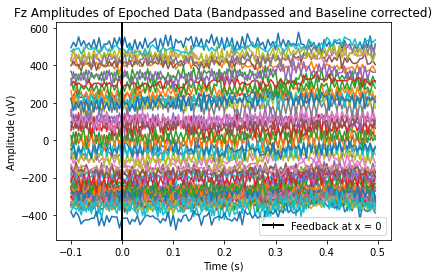

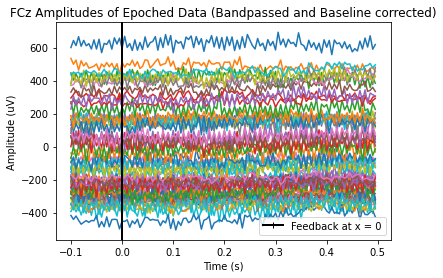

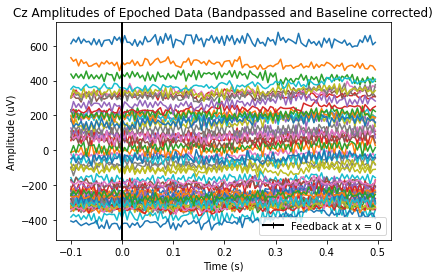

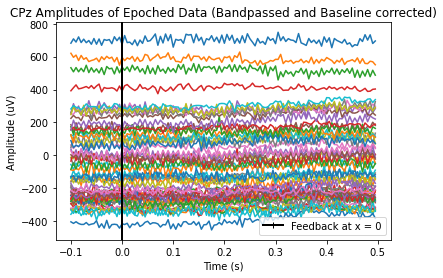

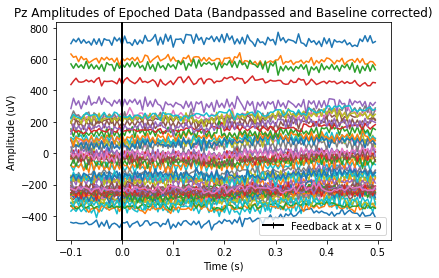

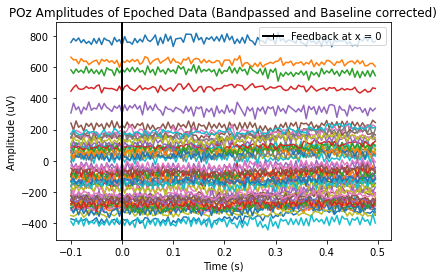

In [11]:
#Not baseline corrected no filter
x = np.arange(-0.1,0.5,0.005) # length = 120
train = extract_data(train_files[:1], -0.4, False, False)
train = train[1:,:,:]

for i, c in enumerate(channels):
    first_electrode = train[:,:120,i]

    for j in np.arange(60):
        y = first_electrode[j,:]
        plt.plot(x, y)

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (uV)')
    plt.title('{} Amplitudes of Epoched Data (Bandpassed and Baseline corrected)'.format(c))
    plt.axvline(x=0, marker = '|', linewidth = 2, label = 'Feedback at x = 0', color = 'black')
    plt.legend()
    plt.show()


  0%|          | 0/1 [00:00<?, ?it/s]

Elapsed Time: 1 seconds


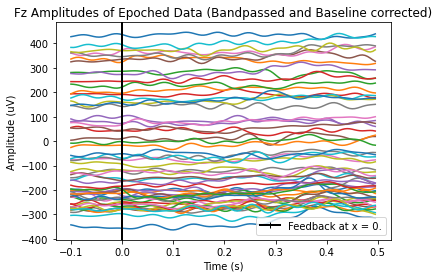

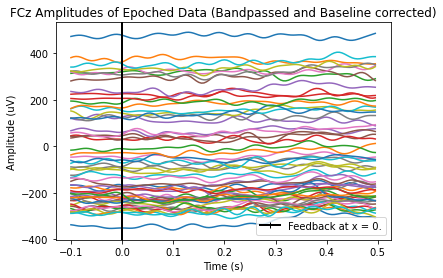

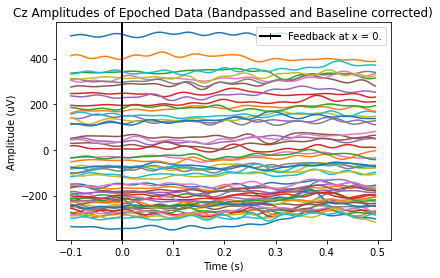

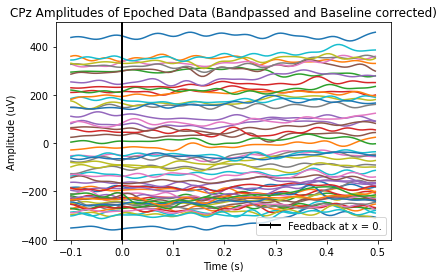

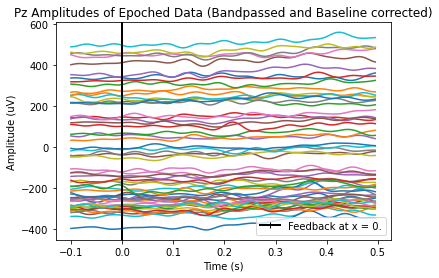

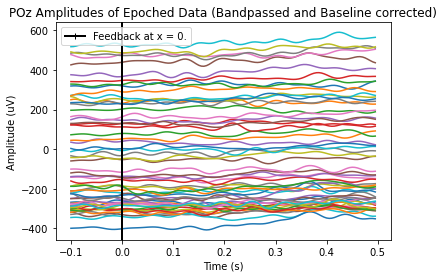

In [12]:
#Bandpassed, baseline not corrected
x = np.arange(-0.1,0.5,0.005)
train = extract_data(train_files[:1], -0.4, baseline = False, bandpass = True)
train = train[1:,:,:]

for i, c in enumerate(channels):
    first_electrode = train[:,:120,i]

    for j in np.arange(60):
        y = first_electrode[j,:]
        plt.plot(x, y)

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (uV)')
    plt.title('{} Amplitudes of Epoched Data (Bandpassed and Baseline corrected)'.format(c))
    plt.axvline(x=0, marker = '|', linewidth = 2, label = 'Feedback at x = 0.', color = 'black')
    plt.legend()
    plt.show()


  0%|          | 0/1 [00:00<?, ?it/s]

Elapsed Time: 1 seconds
(60, 120, 6)


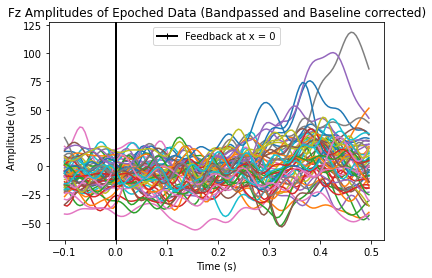

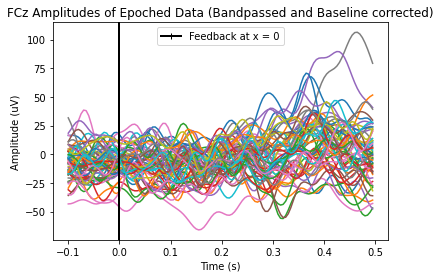

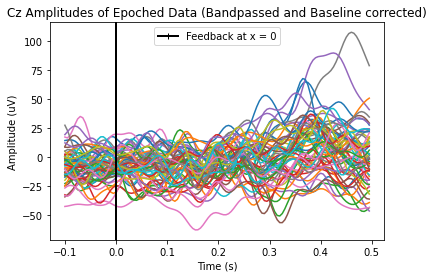

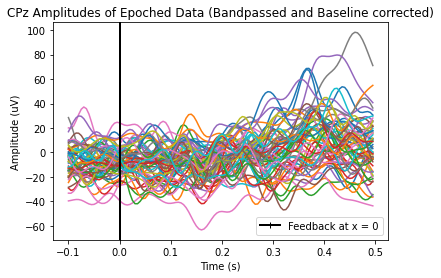

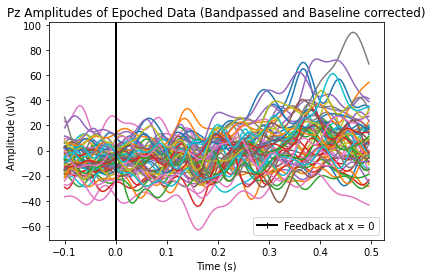

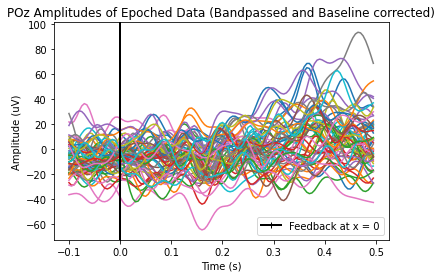

In [13]:
#Bandpassed, and baseline corrected
x = np.arange(-0.1,0.5,0.005)
train = extract_data(train_files[:1], -0.4, baseline = True, bandpass = True)
train = train[1:,:,:]
print(train.shape)

for i, c in enumerate(channels):
    first_electrode = train[:,:120,i]

    for j in np.arange(60):
        y = first_electrode[j,:]
        plt.plot(x, y)

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (uV)')
    plt.title('{} Amplitudes of Epoched Data (Bandpassed and Baseline corrected)'.format(c))
    plt.axvline(x=0, marker = '|', linewidth = 2, label = 'Feedback at x = 0', color = 'black')
    plt.legend()
    plt.show()


In [14]:
# 1. Split data by correct / incorrect data

f = 'data/TrainLabels.csv'
train_labels = pd.read_csv(f)
train_labels = train_labels.Prediction.values
# print(train_labels.shape)

train_filtered = np.load('data/X_train_bwbs.npy')
# print(train_filtered.shape)

X_train_correct, X_train_incorrect = [], []
for i in range(len(train_labels)):
    label = train_labels[i]
    if label:
        X_train_correct.append(train_filtered[i])
    else:
        X_train_incorrect.append(train_filtered[i])

X_train_correct = np.array(X_train_correct)
X_train_incorrect = np.array(X_train_incorrect)

np.save('data/X_train_correct.npy', X_train_correct)
np.save('data/X_train_incorrect.npy', X_train_incorrect)

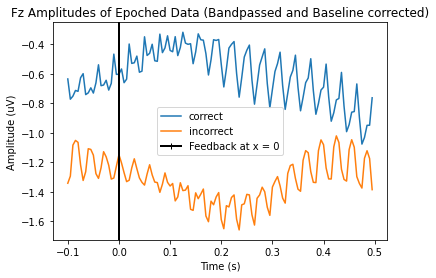

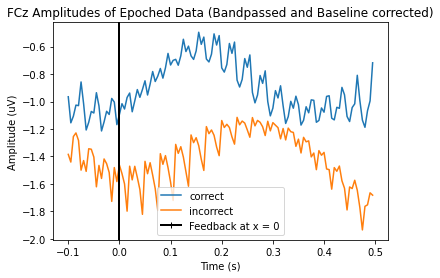

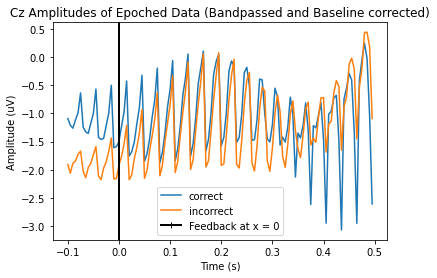

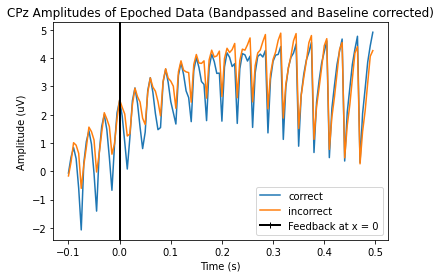

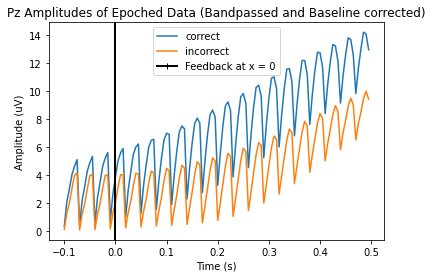

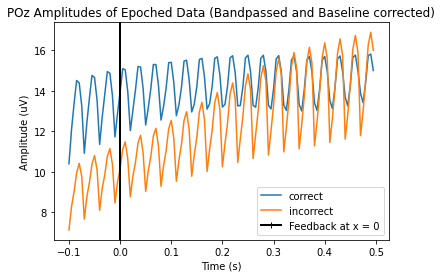

In [15]:
# 2. Take average for graph instead of displaying all lines

#Not baseline corrected no filter
x = np.arange(-0.1,0.5,0.005) # length = 120
X_train_correct = np.load('data/X_train_correct.npy')
X_train_incorrect = np.load('data/X_train_incorrect.npy')
# print(X_train_correct.shape)

for i, c in enumerate(channels):
    correct, correct_mean = X_train_correct[:,i,:], []
    incorrect, incorrect_mean = X_train_incorrect[:,i,:], []
    
    for j in range(len(x)):
        correct_mean.append(sum(correct[:, j]) / len(correct))
        incorrect_mean.append(sum(incorrect[:, j]) / len(incorrect))
    
    plt.plot(x, correct_mean, label='correct')
    plt.plot(x, incorrect_mean, label='incorrect')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (uV)')
    plt.title('{} Amplitudes of Epoched Data (Bandpassed and Baseline corrected)'.format(c))
    plt.axvline(x=0, marker = '|', linewidth = 2, label = 'Feedback at x = 0', color = 'black')
    plt.legend()
    plt.show()
    

In [16]:
# before epoch & filtering
eeg_df_ = copy.deepcopy(eeg_df)
eeg = eeg_df['eeg_signals']
if len(new_ref) == 0:
    # Calculate activity of our current reference
    ref = -1 * np.sum(eeg, axis=1) / (eeg.shape[1] + 1)

    # Create a matrix of our reference and add its activity to eeg
    eeg += np.repeat([ref], eeg.shape[1], axis=0).T

    
    
sos = signal.butter(order, coeffs, btype, fs=fs, output='sos') # fs=200, btype = bandpass, order = 2 - 3, coeffs = [1, 30]ish
filt = signal.sosfiltfilt(sos, eeg, axis=0) # timepoints x num_chanels, axis = 1

b = signal.firwin(numtaps=order, cutoff=coeffs, pass_zero=btype, fs=fs) # order = odd number (31 - 201)
a = 1
filt = signal.filtfilt(b, a, eeg, axis=0)

#filter order = 2, [1, 20], butterworth,

NameError: name 'eeg_df' is not defined